# Trophic position, in the Arctic Ocean. To create the maps that I want, I think I need to find this remmapped. So I will attempt to do this! 

In [1]:
%matplotlib inline
import warnings
warnings.simplefilter("ignore") # Silence warnings
#import hvplot.xarray
import xarray as xr
import cartopy.crs as ccrs

#import geoviews as gv
#import holoviews as hv
import numpy as np
#import math
#from matplotlib.pyplot import figure

# MatPlotlib
import matplotlib.pyplot as plt
#from matplotlib import pylab

# Scientific libraries
from numpy import arange,array,ones
from scipy import stats

#import seaborn as sns
#import scipy.io as sio

#import numpy.ma as ma
from netCDF4 import Dataset as NetCDFFile
import glob
#import pylab 
#from copy import deepcopy
import pandas as pd
import os
import matplotlib.gridspec as gridspec
import matplotlib
import cartopy
import matplotlib.colors as colors
from mpl_toolkits.basemap import Basemap
#import cmocean
#from cartopy.util import add_cyclic_point

In [2]:
def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""

    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:

    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)

In [3]:
class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        if clip is None:
            clip = self.clip

        result, is_scalar = self.process_value(value)

        self.autoscale_None(result)
        vmin, vmax, midpoint = self.vmin, self.vmax, self.midpoint

        if not (vmin < midpoint < vmax):
            raise ValueError("midpoint must be between maxvalue and minvalue.")
        elif vmin == vmax:
            result.fill(0) # Or should it be all masked? Or 0.5?
        elif vmin > vmax:
            raise ValueError("maxvalue must be bigger than minvalue")
        else:
            vmin = float(vmin)
            vmax = float(vmax)
            if clip:
                mask = np.ma.getmask(result)
                result = np.ma.array(np.clip(result.filled(vmax), vmin, vmax),
                                  mask=mask)

            # ma division is very slow; we can take a shortcut
            resdat = result.data

            #First scale to -1 to 1 range, than to from 0 to 1.
            resdat -= midpoint
            resdat[resdat>0] /= abs(vmax - midpoint)
            resdat[resdat<0] /= abs(vmin - midpoint)

            resdat /= 2.
            resdat += 0.5
            result = np.ma.array(resdat, mask=result.mask, copy=False)

        if is_scalar:
            result = result[0]
        return result


In [4]:
def adjust_pop_grid(tlon,tlat,field):
    nj = tlon.shape[0]
    ni = tlon.shape[1]
    xL = int(ni/2 - 1)
    xR = int(xL + ni)

    tlon = np.where(np.greater_equal(tlon,np.min(tlon[:,0])),tlon-360.,tlon)
    lon  = np.concatenate((tlon,tlon+360.),1)
    lon = lon[:,xL:xR]

    if ni == 320:
        lon[367:-3,0] = lon[367:-3,0]+360.
    lon = lon - 360.
    lon = np.hstack((lon,lon[:,0:1]+360.))
    if ni == 320:
        lon[367:,-1] = lon[367:,-1] - 360.

    #-- trick cartopy into doing the right thing:
    #   it gets confused when the cyclic coords are identical
    lon[:,0] = lon[:,0]-1e-8

    #-- periodicity
    lat  = np.concatenate((tlat,tlat),1)
    lat = lat[:,xL:xR]
    lat = np.hstack((lat,lat[:,0:1]))

    field = np.ma.concatenate((field,field),1)
    field = field[:,xL:xR]
    field = np.ma.hstack((field,field[:,0:1]))
    return lon,lat,field

In [5]:
import re
numbers = re.compile(r'(\d+)')
def numericalSort(value):
    parts = numbers.split(value)
    parts[1::2] = map(int, parts[1::2])
    return parts

In [6]:
## Campaign 2nd Cycle 
campaign_20yr = '/glade/campaign/cesm/development/bgcwg/projects/marbl-spectra/GNG595_2ndcycle_1990-2009_clim/GNG595_clim_1990-2009'
campaign_full = '/glade/campaign/cesm/development/bgcwg/projects/marbl-spectra/g.e21.G1850ECOIAF.t62_g17.marbl0_33.GNG595/ocn/hist/'
newNCDFfiles1 = sorted(glob.glob(f'{campaign_20yr}_*.nc', recursive=True),
                      key=numericalSort)

ds = xr.open_mfdataset(newNCDFfiles1,concat_dim='time', combine='nested')

In [7]:
ds

<xarray.Dataset>
Dimensions:                           (time: 12, d2: 2, moc_comp: 3, transport_comp: 5, transport_reg: 2, z_t: 60, z_t_150m: 15, z_w: 60, z_w_top: 60, z_w_bot: 60, lat_aux_grid: 395, moc_z: 61, nlat: 384, nlon: 320)
Coordinates: (12/14)
    transport_components              (transport_comp) |S384 dask.array<chunksize=(5,), meta=np.ndarray>
    transport_regions                 (transport_reg) |S384 dask.array<chunksize=(2,), meta=np.ndarray>
  * time                              (time) object 0104-02-01 00:00:00 ... 0...
  * z_t                               (z_t) float32 500.0 1.5e+03 ... 5.375e+05
  * z_t_150m                          (z_t_150m) float32 500.0 ... 1.45e+04
  * z_w                               (z_w) float32 0.0 1e+03 ... 5e+05 5.25e+05
    ...                                ...
  * lat_aux_grid                      (lat_aux_grid) float32 -79.49 ... 90.0
  * moc_z                             (moc_z) float32 0.0 1e+03 ... 5.5e+05
    ULONG                             (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    ULAT                              (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLONG                             (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLAT                              (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
Dimensions without coordinates: d2, moc_comp, transport_comp, transport_reg, nlat, nlon
Data variables: (12/750)
    time_bound                        (time, d2) object dask.array<chunksize=(1, 2), meta=np.ndarray>
    moc_components                    (time, moc_comp) |S384 dask.array<chunksize=(1, 3), meta=np.ndarray>
    dz                                (time, z_t) float32 dask.array<chunksize=(1, 60), meta=np.ndarray>
    dzw                               (time, z_w) float32 dask.array<chunksize=(1, 60), meta=np.ndarray>
    KMT                               (time, nlat, nlon) float64 dask.array<chunksize=(1, 384, 320), meta=np.ndarray>
    KMU                               (time, nlat, nlon) float64 dask.array<chunksize=(1, 384, 320), meta=np.ndarray>
    ...                                ...
    XBLT                              (time, nlat, nlon) float32 dask.array<chunksize=(1, 384, 320), meta=np.ndarray>
    TBLT                              (time, nlat, nlon) float32 dask.array<chunksize=(1, 384, 320), meta=np.ndarray>
    BSF                               (time, nlat, nlon) float32 dask.array<chunksize=(1, 384, 320), meta=np.ndarray>
    MOC                               (time, transport_reg, moc_comp, moc_z, lat_aux_grid) float32 dask.array<chunksize=(1, 2, 3, 61, 395), meta=np.ndarray>
    N_HEAT                            (time, transport_reg, transport_comp, lat_aux_grid) float32 dask.array<chunksize=(1, 2, 5, 395), meta=np.ndarray>
    N_SALT                            (time, transport_reg, transport_comp, lat_aux_grid) float32 dask.array<chunksize=(1, 2, 5, 395), meta=np.ndarray>
Attributes:
    title:             g.e21.G1850ECOIAF.t62_g17.marbl0_33.GNG595
    history:           Thu Aug 19 14:15:38 2021: nces g.e21.G1850ECOIAF.t62_g...
    Conventions:       CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-cu...
    time_period_freq:  month_1
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    contents:          Diagnostic and Prognostic Variables
    source:            CCSM POP2, the CCSM Ocean Component
    revision:          $Id: tavg.F90 89644 2018-08-04 14:26:01Z klindsay $
    calendar:          All years have exactly  365 days.
    start_time:        This dataset was created on 2021-08-13 at 23:16:30.7
    cell_methods:      cell_methods = time: mean ==> the variable values are ...
    NCO:               netCDF Operators version 4.9.5 (Homepage = http://nco....

### Calculating Zooplankton Mean Torphic Level

In [8]:
## Gaby's Path 
jluo_path = '/glade/u/home/jluo/cesm_scripts/size_structured/nl_input/cases/g.e21.G1850ECOIAF.t62_g17.marbl0_33.'
gabyn_path = '/glade/work/gabyn/case_notes/spectral_cases/g.e21.G1850ECOIAF.t62_g17.marbl0_33.'
nl_config = os.path.join(''+gabyn_path+'GNG595/data/')
sizes = pd.read_csv(nl_config+'plankton_sizes.csv')
sizes = sizes.sort_values('mmolC')

sizes

type  sname      mass_ugC       vol_um3     ESD_mm  Qp_fixed  \
1   phyto     pp  9.266989e-08  3.706795e-01   0.000891  0.004651   
2   phyto    mp1  8.241979e-06  1.805089e+01   0.003255  0.006824   
0   phyto   diaz  5.499929e-05  1.227865e+02   0.006167  0.003333   
3   phyto    mp2  8.888712e-05  8.790197e+02   0.011885  0.008656   
6   phyto  diat1  5.004513e-04  1.327390e+04   0.029376  0.010289   
9     zoo   zoo1  2.803686e-03  2.355042e+04   0.035563  0.008547   
7   phyto  diat2  3.803133e-03  1.326626e+05   0.063278  0.012602   
4   phyto    mp3  4.830334e-03  4.280541e+04   0.043401  0.012907   
8   phyto  diat3  2.890156e-02  1.325863e+06   0.136301  0.015435   
10    zoo   zoo2  8.933984e-02  7.447577e+05   0.112462  0.008547   
5   phyto    mp4  1.855836e-01  2.084484e+06   0.158489  0.018590   
11    zoo   zoo3  2.825280e+00  2.355219e+07   0.355640  0.008547   
12    zoo   zoo4  8.934658e+01  7.448139e+08   1.124647  0.008547   
13    zoo   zoo5  2.825494e+03  2.355397e+10   3.556492  0.008547   
14    zoo   zoo6  8.935332e+04  7.448701e+11  11.246757  0.008547   

           mmolC  
1   7.715418e-12  
2   6.862025e-10  
0   4.579077e-09  
3   7.400476e-09  
6   4.166608e-08  
9   2.334265e-07  
7   3.166375e-07  
4   4.021592e-07  
8   2.406258e-06  
10  7.438168e-06  
5   1.545114e-05  
11  2.352244e-04  
12  7.438730e-03  
13  2.352422e-01  
14  7.439291e+00

In [9]:
prey_varnames = {}
for i,v in enumerate(sizes.sname):
    prey_varnames[v]=i

In [10]:
pred_varnames = {'zoo3':2,'zoo4':3,'zoo5':4,'zoo6':5}
grazing_vars = [v for v in ds if 'graze' in v and 'zint' not in v]

In [11]:
graze_split = [v.split('_',3) for v in grazing_vars]
graze_split = pd.DataFrame(graze_split)
graze_split = graze_split.rename({0:'var',1:'prey',2:'pred'}, axis=1)
graze_split['var'] = grazing_vars

In [12]:
# clear zeros in the zooplankton carbon biomass
zoo1C = ds.zoo1C.values
zoo2C = ds.zoo2C.values
zoo3C = ds.zoo3C.values
zoo4C = ds.zoo4C.values
zoo5C = ds.zoo5C.values
zoo6C = ds.zoo6C.values

zoo1C[np.where(zoo1C < 0)] = 0
zoo2C[np.where(zoo2C < 0)] = 0
zoo3C[np.where(zoo3C < 0)] = 0
zoo4C[np.where(zoo4C < 0)] = 0
zoo5C[np.where(zoo5C < 0)] = 0
zoo6C[np.where(zoo6C < 0)] = 0

ds.zoo1C.values = zoo1C
ds.zoo2C.values = zoo2C
ds.zoo3C.values = zoo3C
ds.zoo4C.values = zoo4C
ds.zoo5C.values = zoo5C
ds.zoo6C.values = zoo6C

In [13]:
mesozoo_names = { 'mesozoo_names': ['zoo3','zoo4','zoo5','zoo6']}
zn = pd.DataFrame(data=mesozoo_names)

phyto_names = { 'phyto_names': ['pp','mp1','diaz','mp2','diat1','diat2','mp3','diat3','mp4']}
pn = pd.DataFrame(data=phyto_names)

## Calculate the zooplankton mean trophic level at each grid cell 

In [14]:
zoods = xr.DataArray(zoo3C, coords={'time':ds.time, 'z_t_150m':ds.z_t_150m, 'nlat':ds.nlat, 'nlon':ds.nlon},
                      dims=['time', 'z_t_150m', 'nlat', 'nlon'])
zoods = zoods.to_dataset(name='zoo3C')

#zoods['zoo2C'] = xr.DataArray(zoo2C, coords={'time':ds.time, 'z_t_150m':ds.z_t_150m, 'nlat':ds.nlat, 'nlon':ds.nlon},
#                      dims=['time', 'z_t_150m', 'nlat', 'nlon'])
#zoods['zoo1C'] = xr.DataArray(zoo1C, coords={'time':ds.time, 'z_t_150m':ds.z_t_150m, 'nlat':ds.nlat, 'nlon':ds.nlon},
#                      dims=['time', 'z_t_150m', 'nlat', 'nlon'])
zoods['zoo4C'] = xr.DataArray(zoo4C, coords={'time':ds.time, 'z_t_150m':ds.z_t_150m, 'nlat':ds.nlat, 'nlon':ds.nlon},
                      dims=['time', 'z_t_150m', 'nlat', 'nlon'])
zoods['zoo5C'] = xr.DataArray(zoo5C, coords={'time':ds.time, 'z_t_150m':ds.z_t_150m, 'nlat':ds.nlat, 'nlon':ds.nlon},
                      dims=['time', 'z_t_150m', 'nlat', 'nlon'])
zoods['zoo6C'] = xr.DataArray(zoo6C, coords={'time':ds.time, 'z_t_150m':ds.z_t_150m, 'nlat':ds.nlat, 'nlon':ds.nlon},
                      dims=['time', 'z_t_150m', 'nlat', 'nlon'])

## Grazing flux based on trophic level 

In [15]:
# set trophic level for phyto = 1
tmpOnes = np.ones(shape=ds.diazC.shape)
tlvals = {}
for v in pn.phyto_names:
    tlvals[v]=tmpOnes

# set trophic level for zoo = NaN initially
tmp = tmpOnes.copy()
tmp[:] = np.nan
for v in zn.mesozoo_names:
    tlvals[v]=tmp
    
zoo = ['zoo3','zoo4','zoo5','zoo6']

In [16]:
for i,vs in enumerate(zn.mesozoo_names):
    
    # pull out the appropriate grazing variables in the history file
    graze_vars = [v for v in ds if re.match('graze_(.*)_'+vs,v)]
    
    # holder for the grazing values
    shape = ds[graze_vars[0]].shape + (len(graze_vars),)

    graze_vals = np.empty(shape=shape)
    graze_tl = np.ones(shape=shape)
    
    for gi,gv in enumerate(graze_vars):
        
        # pull out identity of prey
        g,prey,pred = gv.split('_',3)
        print(prey,pred)
        
        # if prey is zooplankton, then apply alternate trophic level
        if prey in zoo:
            graze_tl[...,gi]=tlvals[prey]
        
        graze_vals[...,gi] = ds[gv].values # Ellipses select the last slice
    # graze_vals*grazetl/graze_vals    
    tlvals[vs] = 1 + (np.sum(graze_vals * graze_tl, axis=-1) / np.sum(graze_vals, axis=-1)) # axis=-1 means sum over the last axis

diaz zoo3
mp2 zoo3
mp3 zoo3
diat1 zoo3
diat2 zoo3
diat3 zoo3
zoo1 zoo3
zoo2 zoo3
mp2 zoo4
mp3 zoo4
mp4 zoo4
diat1 zoo4
diat2 zoo4
diat3 zoo4
zoo2 zoo4
zoo3 zoo4
mp3 zoo5
mp4 zoo5
diat2 zoo5
diat3 zoo5
zoo3 zoo5
zoo4 zoo5
mp4 zoo6
diat3 zoo6
zoo4 zoo6
zoo5 zoo6


In [17]:
np.nanmax(tlvals['zoo6'])

4.596352976443045

In [18]:
np.nanmax(tlvals['zoo3'])

2.0

In [19]:
#zoods['zoo1TL'] = xr.DataArray(tlvals['zoo1'], coords={'time':ds.time, 'z_t_150m':ds.z_t_150m, 'nlat':ds.nlat, 'nlon':ds.nlon},
#                      dims=['time', 'z_t_150m', 'nlat', 'nlon'])
#zoods['zoo2TL'] = xr.DataArray(tlvals['zoo2'], coords={'time':ds.time, 'z_t_150m':ds.z_t_150m, 'nlat':ds.nlat, 'nlon':ds.nlon},
#                      dims=['time', 'z_t_150m', 'nlat', 'nlon'])
zoods['zoo3TL'] = xr.DataArray(tlvals['zoo3'], coords={'time':ds.time, 'z_t_150m':ds.z_t_150m, 'nlat':ds.nlat, 'nlon':ds.nlon},
                      dims=['time', 'z_t_150m', 'nlat', 'nlon'])
zoods['zoo4TL'] = xr.DataArray(tlvals['zoo4'], coords={'time':ds.time, 'z_t_150m':ds.z_t_150m, 'nlat':ds.nlat, 'nlon':ds.nlon},
                      dims=['time', 'z_t_150m', 'nlat', 'nlon'])
zoods['zoo5TL'] = xr.DataArray(tlvals['zoo5'], coords={'time':ds.time, 'z_t_150m':ds.z_t_150m, 'nlat':ds.nlat, 'nlon':ds.nlon},
                      dims=['time', 'z_t_150m', 'nlat', 'nlon'])
zoods['zoo6TL'] = xr.DataArray(tlvals['zoo6'], coords={'time':ds.time, 'z_t_150m':ds.z_t_150m, 'nlat':ds.nlat, 'nlon':ds.nlon},
                      dims=['time', 'z_t_150m', 'nlat', 'nlon'])

In [20]:
zoods['zooTL_g'] = xr.concat([zoods[v+'TL'] for v in ['zoo3','zoo4','zoo5','zoo6']],dim='var').mean(dim='var')

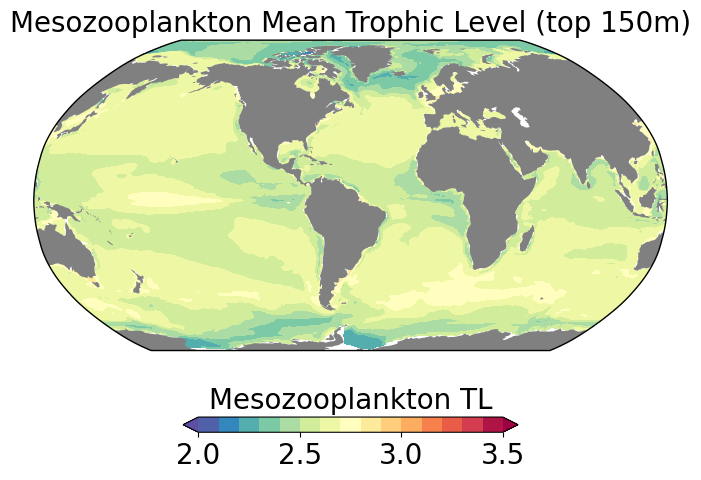

In [43]:
lev = np.arange(2, 3.6, 0.1)
norm = colors.TwoSlopeNorm(vmin=lev[0], vmax=lev[-1], vcenter=2.75)

fig = plt.figure(figsize=(7, 5))
lon, lat, annual = adjust_pop_grid(ds.TLONG, ds.TLAT, zoods.zooTL_g.mean(dim=['z_t_150m','time']).values)
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson(central_longitude=305.0))
cf = ax.contourf(lon, lat, annual, vmin=2, vmax=3.5,levels=lev,norm=norm, extend='both',cmap='Spectral_r',transform=ccrs.PlateCarree());
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
cb = plt.colorbar(cf, ticks=[2, 2.5,3, 3.5],shrink=0.5,orientation='horizontal')
cb.ax.tick_params(labelsize=20)
cb.ax.set_title('Mesozooplankton TL', fontsize =20)
ax.set_title('Mesozooplankton Mean Trophic Level (top 150m)', fontsize =20);
fig.tight_layout()

## Start From here to just do the quarterly trophic position AO....

In [47]:
zoods.zooTL_g.shape

(12, 15, 384, 320)

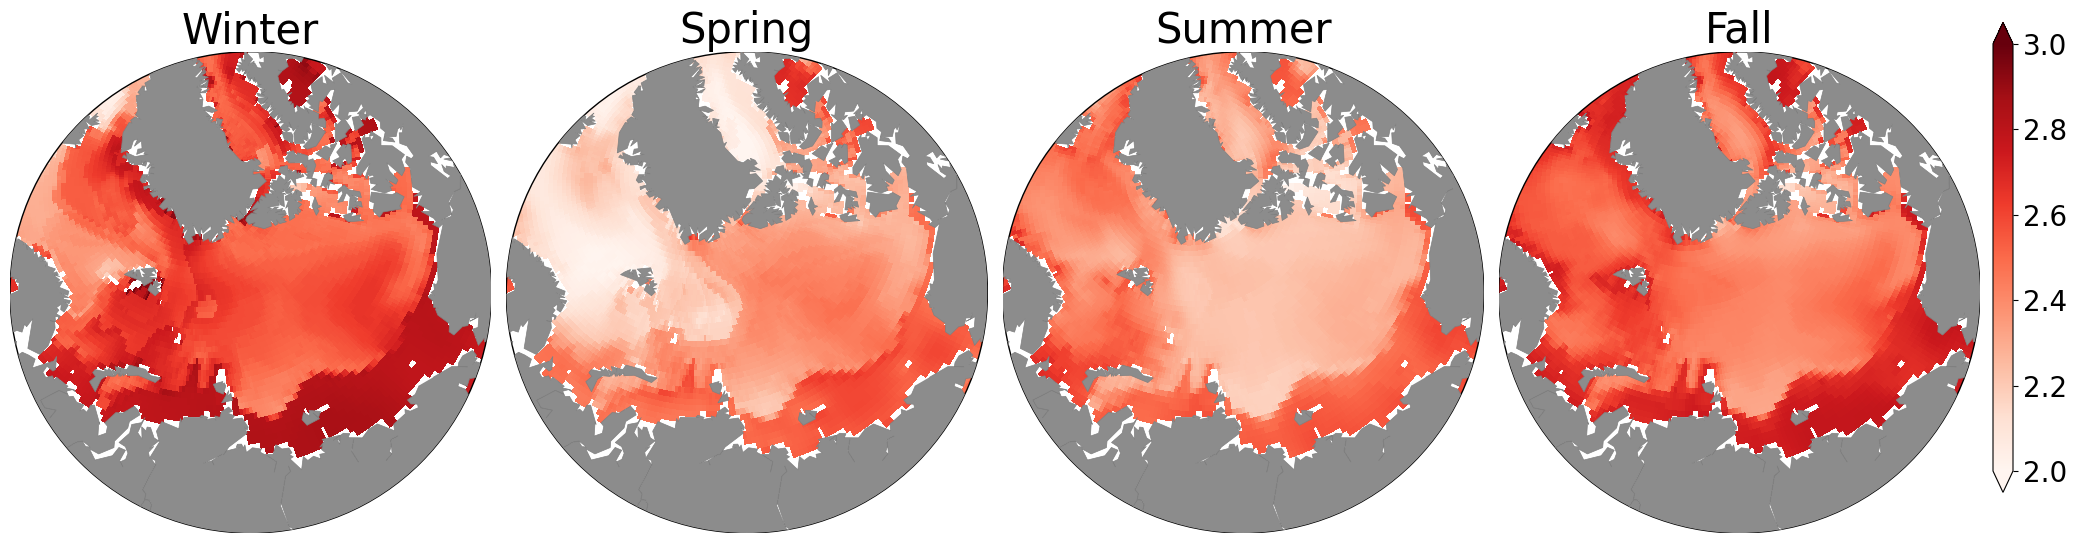

In [48]:
fig = plt.figure(figsize=(20, 10))
#TL_150m = zoods.zooTL_g.mean(dim=['z_t_150m']).values
TL_150m = np.nanmean(zoods.zooTL_g,axis=1)
## WINTER 
ax = fig.add_subplot(1, 4, 1)
lon, lat, winter = adjust_pop_grid(ds.TLONG, ds.TLAT, TL_150m[list(range(2)) + [-1],:,:].mean(axis=0))
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
x,y = m(lon, lat)
cf = m.pcolor(x,y,winter,cmap='Reds', vmin = 2, vmax = 3)
m.drawcoastlines(linewidth=0.5, linestyle='solid', color='gray', antialiased=1, ax=None, zorder=None)
m.fillcontinents(color='0.55', lake_color=None, ax=None, zorder=None, alpha=None)
ax.set_title('Winter', fontsize =30)

## SPRING
ax = fig.add_subplot(1, 4, 2)
lon, lat, spring = adjust_pop_grid(ds.TLONG, ds.TLAT, TL_150m[2:5,:,:].mean(axis=0))
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
x,y = m(lon, lat)
cf = m.pcolor(x,y,spring,cmap='Reds', vmin = 2, vmax = 3)
m.drawcoastlines(linewidth=0.5, linestyle='solid', color='gray', antialiased=1, ax=None, zorder=None)
m.fillcontinents(color='0.55', lake_color=None, ax=None, zorder=None, alpha=None)
ax.set_title('Spring', fontsize =30)

## SUMMER
ax = fig.add_subplot(1, 4, 3)
lon, lat, summer = adjust_pop_grid(ds.TLONG, ds.TLAT, TL_150m[5:8,:,:].mean(axis=0))
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
x,y = m(lon, lat)
cf = m.pcolor(x,y,summer,cmap='Reds', vmin = 2, vmax = 3)
m.drawcoastlines(linewidth=0.5, linestyle='solid', color='gray', antialiased=1, ax=None, zorder=None)
m.fillcontinents(color='0.55', lake_color=None, ax=None, zorder=None, alpha=None)
ax.set_title('Summer', fontsize =30)


##FALL
ax = fig.add_subplot(1, 4, 4)
lon, lat, fall = adjust_pop_grid(ds.TLONG, ds.TLAT, TL_150m[8:11,:,:].mean(axis=0))
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
x,y = m(lon, lat)
cf = m.pcolor(x,y,fall,cmap='Reds', vmin = 2, vmax = 3)
m.drawcoastlines(linewidth=0.5, linestyle='solid', color='gray', antialiased=1, ax=None, zorder=None)
m.fillcontinents(color='0.55', lake_color=None, ax=None, zorder=None, alpha=None)
ax.set_title('Fall', fontsize =30);
cbar_ax = fig.add_axes([0.999, 0.3, 0.01, 0.47])
cb = fig.colorbar(cf, shrink=0.1, extend ='both',orientation='vertical', cax=cbar_ax)
cb.ax.tick_params(labelsize=20)
fig.tight_layout()
fig.savefig('/glade/work/gabyn/case_notes/analysis_figures/TL_seasonal_mesozooplankton_AO_20year_clim.png', dpi=600, bbox_inches='tight')

In [21]:
## Save 
np.save("mesozoo_mean_TL.npy", zoods.zooTL_g)